# Wastewater injection from fracking became widespread in Oklahoma since 2010, and it may cause more earthquakes in the region.<br>
## 1. EDA of earthquakes overtime
## 2. Estimate the mean interearthquake times
## 3. Did earthquake frequency changed after fracking became widespread
## 4. Did earthquake magnitudes changed after fracking became widespread

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst

In [2]:
df = pd.read_csv('oklahoma_earthquakes_1950-2017.csv', skiprows=2, parse_dates=['time'])
display(df.head())
df.info()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,loc_name,loc_admin1,loc_admin2,loc_cc
0,1974-12-16 02:30:21.400,35.330,-97.480,10.0,2.6,ml,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,m,tul,Moore,Oklahoma,Cleveland County,US
1,1975-09-13 01:25:02.800,34.139,-97.369,5.0,3.4,lg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,tul,Wilson,Oklahoma,Carter County,US
2,1975-10-12 02:58:11.200,34.816,-97.406,20.0,3.2,lg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,tul,Maysville,Oklahoma,Garvin County,US
3,1975-11-29 14:29:40.900,34.521,-97.347,5.0,3.5,lg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,slm,Wynnewood,Oklahoma,Garvin County,US
4,1976-04-16 18:59:44.200,36.107,-99.875,5.0,3.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,tul,Arnett,Oklahoma,Ellis County,US


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8978 entries, 0 to 8977
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             8978 non-null   datetime64[ns]
 1   latitude         8978 non-null   float64       
 2   longitude        8978 non-null   float64       
 3   depth            8978 non-null   float64       
 4   mag              8978 non-null   float64       
 5   magType          8970 non-null   object        
 6   nst              722 non-null    float64       
 7   gap              8128 non-null   float64       
 8   dmin             916 non-null    float64       
 9   rms              8318 non-null   float64       
 10  net              8978 non-null   object        
 11  id               8978 non-null   object        
 12  updated          8978 non-null   object        
 13  place            8978 non-null   object        
 14  type             8978 non-null   object 

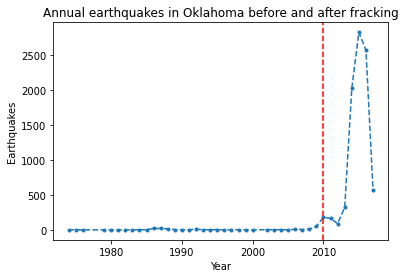

In [3]:
# EDA
# 1. Number of earthquakes by year
annual_eq = df.groupby(df['time'].dt.year)['time'].count()

_ = plt.plot(annual_eq, linestyle='--', marker='.')
_ = plt.axvline(x=2010, color='r', linestyle='--')
_ = plt.title('Annual earthquakes in Oklahoma before and after fracking')
_ = plt.xlabel('Year')
_ = plt.ylabel('Earthquakes')

plt.show()

In [4]:
# 2. Estimating mean inter-earthquake times
# sort df by time
df = df.sort_values(by='time')
# calculate inter-earthquake times
intereq_time = df['time'].diff().dropna().dt.days
print('Before filtering out aftershocks')
display(intereq_time.describe())
# filter out aftershocks
aftershock_threshold = 5 #days
intereq_time = intereq_time[intereq_time >= 10]
print('After filtering out aftershocks')
display(intereq_time.describe())

Before filtering out aftershocks


count    8977.000000
mean        1.559318
std        20.736658
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1144.000000
Name: time, dtype: float64

After filtering out aftershocks


count     144.000000
mean       88.895833
std       138.384117
min        10.000000
25%        15.000000
50%        34.500000
75%       101.500000
max      1144.000000
Name: time, dtype: float64

Aftershocks happen within 5 days based on our filter

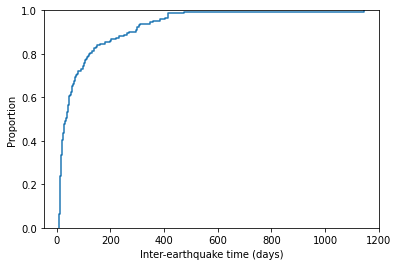

In [5]:
# visualize
_ = sns.ecdfplot(data=intereq_time)
_ = plt.xlabel('Inter-earthquake time (days)')

Observed mean = 88.89583333333333 days


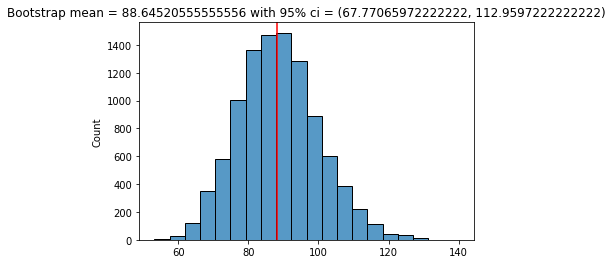

In [6]:
# calculate observed statistics
mean_intereq_time = np.mean(intereq_time)
print('Observed mean =', mean_intereq_time, 'days')

# drawbootstrap replicates of the mean to estimate the population parameter
bs_reps = dcst.draw_bs_reps(intereq_time, np.mean, 10000)
bs_mean = np.mean(bs_reps)
bs_median = np.median(bs_reps)
bs_ci = tuple(np.percentile(bs_reps, [2.5,97.5]))
# print('Bootstrap mean = {} with 95% ci = {}'.format(bs_mean, bs_ci))

# plot histogram
_ = sns.histplot(bs_reps, bins=20)
_ = plt.axvline(x=bs_median, color='red')
_ = plt.title('Bootstrap mean = {} with 95% ci = {}'.format(bs_mean, bs_ci))
plt.show()

In [7]:
# 3. Did earthquake frequency changed after fracking became widespread
'''
Null hypothesis: Before and after 2010 have the same mean inter-earthquake time
Test stat: Mean inter-earthquake time difference
At least as extreme as: Observed difference in mean inter-earthquake time
'''
# split df to before and after
before_fracking = df[df.time.dt.year < 2010]['time'].diff().dropna().dt.days
after_fracking = df[df.time.dt.year >= 2010]['time'].diff().dropna().dt.days
# filter out aftershocks
before_fracking = before_fracking[before_fracking >= aftershock_threshold]
after_fracking = after_fracking[after_fracking >= aftershock_threshold]
# calculate observed statistics
mean_diff_obs = np.mean(before_fracking) - np.mean(after_fracking)
print('Observed mean difference =', mean_diff_obs, 'days')

Observed mean difference = 80.14310554686142 days


In [8]:
# shift the means of before and after to a common mean
common_mean = np.mean(df['time'].diff().dropna().dt.days)
before_fracking_shifted = before_fracking - np.mean(before_fracking) + common_mean
after_fracking_shifted = after_fracking - np.mean(after_fracking) + common_mean
# draw bs reps from both sample, subtract to get our test statistic
before_bs_reps = dcst.draw_bs_reps(before_fracking_shifted, np.mean, 10000)
after_bs_reps = dcst.draw_bs_reps(after_fracking_shifted, np.mean, 10000)
test_stat_bs_reps = before_bs_reps - after_bs_reps

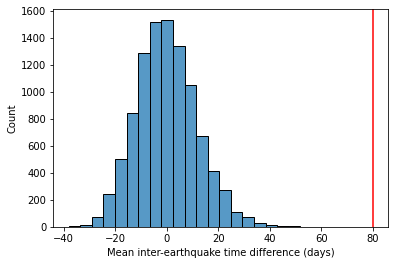

p value: 0.0


In [9]:
# visualize
_ = sns.histplot(data=test_stat_bs_reps, bins=20)
_ = plt.axvline(x=mean_diff_obs, color='red')
_ = plt.xlabel('Mean inter-earthquake time difference (days)')
plt.show()
# calculate p-value
p_value = sum(test_stat_bs_reps >= mean_diff_obs) / len(test_stat_bs_reps)
print('p value:', p_value)

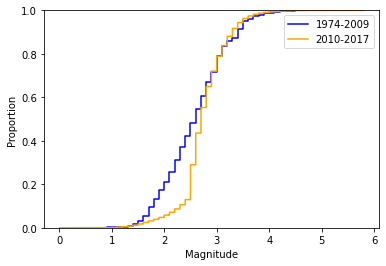

In [10]:
# 4. Did earthquake magnitudes changed after fracking became widespread
# EDA magnitudes before and after
before_fracking_mag = df[df.time.dt.year < 2010]['mag']
after_fracking_mag = df[df.time.dt.year >= 2010]['mag']
_ = sns.ecdfplot(data=before_fracking_mag, color='blue')
_ = sns.ecdfplot(data=after_fracking_mag, color='orange')
_ = plt.xlabel('Magnitude')
_ = plt.legend(labels=['1974-2009', '2010-2017'], loc='best')
plt.show()

In [11]:

# observed means
mean_before_fracking_mag = np.mean(before_fracking_mag)
mean_after_fracking_mag = np.mean(after_fracking_mag)
print('Observed means before = {} after = {}'.format(mean_before_fracking_mag, mean_after_fracking_mag))
# estimate parameter, mean of eartquake magnitudes
bs_reps_before = dcst.draw_bs_reps(before_fracking_mag, np.mean, 10000)
bs_reps_after = dcst.draw_bs_reps(before_fracking_mag, np.mean, 10000)
ci_before = np.percentile(bs_reps_before, [2.5,97.5])
ci_after = np.percentile(bs_reps_after, [2.5,97.5])
# print out
print('Bootstrap mean before = {} with 95% ci = {}'.format(np.mean(bs_reps_before) , ci_before))
print('Bootstrap mean after = {} with 95% ci = {}'.format(np.mean(bs_reps_after) , ci_after))

Observed means before = 2.578403755868545 after = 2.7462920707358816
Bootstrap mean before = 2.577051220657277 with 95% ci = [2.49530516 2.65915493]
Bootstrap mean after = 2.5777245070422534 with 95% ci = [2.49576291 2.66197183]


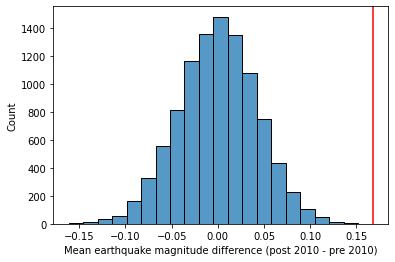

p value: 0.0


In [12]:
# hypothesis test
'''
Null hyp: mean earthquake magnitude difference is 0
Test stat: mean earthquake mag difference
As extreme as the observed diff???
'''
# observed difference
mean_diff_obs = mean_after_fracking_mag - mean_before_fracking_mag
# shift the means of before and after to a common mean
common_mean = np.mean(df['mag'])
before_fracking_mag_shifted = before_fracking_mag - mean_before_fracking_mag + common_mean
after_fracking_mag_shifted = after_fracking_mag - mean_after_fracking_mag + common_mean
# draw bs reps from both sample, subtract to get our test statistic
before_bs_reps = dcst.draw_bs_reps(before_fracking_mag_shifted, np.mean, 10000)
after_bs_reps = dcst.draw_bs_reps(after_fracking_mag_shifted, np.mean, 10000)
test_stat_bs_reps = after_bs_reps - before_bs_reps
# visualize
_ = sns.histplot(data=test_stat_bs_reps, bins=20)
_ = plt.axvline(x=mean_diff_obs, color='red')
_ = plt.xlabel('Mean earthquake magnitude difference (post 2010 - pre 2010)')
plt.show()
# calculate p-value
p_value = sum(test_stat_bs_reps >= mean_diff_obs) / len(test_stat_bs_reps)
print('p value:', p_value)

Quick summary  
1. We got way more earthquakes after fracking became common in 2010.  
2. With aftershock threshold at 5 days, inter-earthquake time is estimated to be 89 days with 95%ci \[68,113\].  
3. We have evidence to reject the null that earthquake frequency has not changed before and after 2010. Observed mean difference = 80.14310554686142 days.   
4. We have evidence to reject the null that earthquake magnitudes has not changed before and after 2010. Observed mean difference =  0.167 (post - pre)